In [3]:
import numpy as np
import sys,os
import matplotlib.pyplot as plt
from scipy.stats import multivariate_t as mvt, norm 
import sklearn
from sklearn.covariance import GraphicalLasso
import scipy
from sklearn.metrics import zero_one_loss
from sklearn.metrics.pairwise import pairwise_kernels
import time
import tqdm
import networkx as nx
from sklearn.datasets import make_sparse_spd_matrix
import pickle

sys.path.insert(0, 'C:/Users/User/Code/DyGraph')

import DyGraph as dg
from utils import calc_one_zero_error, calc_f1, calc_precision, calc_recall, calc_density, calc_roc_auc, calc_balanced_accuaray

In [2]:



def plot_fun1(dict_name, metric, alpha, kappa):
    
    # Plot precision list 
    fig, ax = plt.subplots(2,5, figsize = (20,10))
    l = int(len(alpha)/np.prod(ax.shape))
    a = 0
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):

            metric_loss = []
            if metric == "zero-one":
                for k_idx in range(len(kappa)):
                    loss = np.mean([calc_one_zero_error(dict_name['prec_list'][k], dict_name['theta'][a][k_idx][k]) for k in range(len(dict_name['prec_list']))])
                    metric_loss.append(loss)
            elif metric == "Frobenius":
                for k_idx in range(len(kappa)):
                    loss = np.mean([scipy.linalg.norm(dict_name['prec_list'][k]- dict_name['theta'][a][k_idx][k],ord = 'fro') for k in range(len(dict_name['prec_list']))])
                    metric_loss.append(loss)
            elif metric == "l1":
                for k_idx in range(len(kappa)):
                    loss = np.mean([scipy.linalg.norm(dict_name['prec_list'][k]- dict_name['theta'][a][k_idx][k],ord = 1) for k in range(len(dict_name['prec_list']))])
                    metric_loss.append(loss)
           

            ax[i,j].plot(kappa,metric_loss)
            if i ==1:
                ax[i,j].set_xlabel("Kappa")
            if j == 0:
                ax[i,j].set_ylabel("loss")
            ax[i,j].set_ylim((0,2))
            ax[i,j].set_title(f"{metric}, alpha:{np.round(alpha[a],3)}")
            a+=l

    fig.show()



def plot_all_metric_per_alpha(dict_name, kappa_vals, ylim = [0,1], bbox_to_anchor = (1,1)):
    from scipy.linalg import norm

     # Plot precision list 
    fig, ax = plt.subplots(1,len(kappa_vals), figsize = (5*len(kappa_vals),5))
    for i, k_idx in enumerate(kappa_vals):
        metric_zo = []
        metric_l1 = []
        metric_f = []
        for a in range(len(dict_name['alpha'])):
            loss = np.mean([calc_one_zero_error(dict_name['prec_list'][k], dict_name['theta'][a][k_idx][k]) for k in range(len(dict_name['prec_list']))])
            metric_zo.append(loss)

            loss = np.mean([norm(dict_name['prec_list'][k]- dict_name['theta'][a][k_idx][k],ord = 'fro')/norm(dict_name['prec_list'][k], ord = 'fro') for k in range(len(dict_name['prec_list']))])
            metric_f.append(loss)

            loss = np.mean([norm(dict_name['prec_list'][k]- dict_name['theta'][a][k_idx][k],ord = 1)/norm(dict_name['prec_list'][k], ord = 1) for k in range(len(dict_name['prec_list']))])
            metric_l1.append(loss)

        if len(kappa_vals) == 1:
            ax.plot(dict_name['alpha'], metric_zo, label = 'Zero-one')
            ax.plot(dict_name['alpha'], metric_l1, label = 'l1')
            ax.plot(dict_name['alpha'], metric_f, label = 'Frobenius')
            ax.set_title(f"Kappa {np.round(dict_name['kappa'][k_idx],2)}", fontdict = {'fontsize':24})
            ax.set_xlabel("alpha", fontdict = {'fontsize':24})
            ax.set_ylabel("Average loss", fontdict = {'fontsize':24})
            ax.set_ylim(ylim)
            ax.tick_params(axis='both', which='major', labelsize=20)
            legend  = ax.legend(title = "Metric",fontsize = 14, bbox_to_anchor = bbox_to_anchor)
            legend.get_title().set_fontsize('18')



        else:
            ax[i].plot(dict_name['alpha'], metric_zo, label = 'Zero-one')
            ax[i].plot(dict_name['alpha'], metric_l1, label = 'l1')
            ax[i].plot(dict_name['alpha'], metric_f, label = 'Frobenius')
            ax[i].set_title(f"Kappa {np.round(dict_name['kappa'][k_idx],2)}", fontdict = {'fontsize':24})
            ax[i].set_xlabel("alpha", fontdict = {'fontsize':24})
            if i == 0:
                ax[i].set_ylabel("Average loss", fontdict = {'fontsize':24})
            ax[i].set_ylim(ylim)
            if i == len(kappa_vals)-1:
                #ax[i].legend(bbox_to_anchor = (1.4,1))
                legend  = ax[i].legend(title = "Metric",fontsize = 18, bbox_to_anchor = bbox_to_anchor)
                legend.get_title().set_fontsize('18')

            ax[i].tick_params(axis='both', which='major', labelsize=20)


def plot_edges(list_of_dicts, edges, alpha_idx, kappa_idx):

    # red grey green blue
    colors_light = ['black', '#D0CDC9', '#6EA96E', '#D6F6F6']
    colors_dark = ['#CC1100', '#8B7500','#00688B', '#00688B']

    fig, ax = plt.subplots(1,len(edges), figsize = (5*len(edges),5))

    plot_once_edge = True
    for cnt1, dict_name in enumerate(list_of_dicts):

        d = dict_name['theta'][0][0].shape[1]


        
        for cnt2, e in enumerate(edges):

            if len(edges) == 1:
                if plot_once_edge:
                    ax.plot(dict_name['prec_list'][:,e[0],e[1]], label = "True", color = colors_light[0])
                
                ax.set_title(f"Edge ({e[0]+1}, {e[1]+1}), alpha= {np.round(dict_name['alpha'][alpha_idx],2)}, kappa =  {np.round(dict_name['kappa'][kappa_idx],2)}")
                    
                ax.plot(dict_name['theta'][alpha_idx][kappa_idx][:,e[0],e[1]], label = f"Estimate, n={dict_name['nr_obs_per_graph']}", linestyle = '--', color = colors_dark[cnt1])
                
                ax.legend(bbox_to_anchor = (1,1))
                ax.set_xlabel("Time")
                ax.set_ylabel("Edge weight")
            else:
                if plot_once_edge:
                    ax[cnt2].plot(dict_name['prec_list'][:,e[0],e[1]], label = "True", color = colors_light[0])
                
                ax[cnt2].set_title(f"Edge ({e[0]+1}, {e[1]+1}), alpha= {np.round(dict_name['alpha'][alpha_idx],2)}, kappa =  {np.round(dict_name['kappa'][kappa_idx],2)}")

                ax[cnt2].plot(dict_name['theta'][alpha_idx][kappa_idx][:,e[0],e[1]], label = f"Estimate, n={dict_name['nr_obs_per_graph']}", linestyle = '--', color = colors_dark[cnt1])
                 
                if cnt2 == len(edges)-1:
                    ax[cnt2].legend(bbox_to_anchor = (1,1))
                ax[cnt2].set_xlabel("Time")
                ax[cnt2].set_ylabel("Edge weight")

        plot_once_edge = False


def find_min(change_point_dict):
    from scipy.linalg import norm
    # Find which gives minimum
    current_min_zo = np.inf
    edge_min_zo = [0,0]

    current_min_l1 = np.inf
    edge_min_l1 = [0,0]

    current_min_f = np.inf
    edge_min_f = [0,0]


    for i in range(len(change_point_dict['alpha'])):
        for j in range(len(change_point_dict['kappa'])):
            
            loss = np.mean([calc_one_zero_error(change_point_dict['prec_list'][k], change_point_dict['theta'][i][j][k]) for k in range(len(change_point_dict['prec_list']))])
            if loss < current_min_zo:
                current_min_zo = loss

                edge_min_zo[0] = i
                edge_min_zo[1] = j

            loss = np.mean([norm(change_point_dict['prec_list'][k]- change_point_dict['theta'][i][j][k],ord = 'fro')/norm(change_point_dict['prec_list'][k], ord = 'fro') for k in range(len(change_point_dict['prec_list']))])
            if loss < current_min_f:
                current_min_f = loss

                edge_min_f[0] = i
                edge_min_f[1] = j

            loss = np.mean([norm(change_point_dict['prec_list'][k]- change_point_dict['theta'][i][j][k],ord = 1)/norm(change_point_dict['prec_list'][k], ord = 'fro') for k in range(len(change_point_dict['prec_list']))])
            if loss < current_min_l1:
                current_min_l1 = loss

                edge_min_l1[0] = i
                edge_min_l1[1] = j



    print(f"zo {edge_min_zo} {current_min_zo}")
    print(f"l1 {edge_min_l1}  {current_min_l1}")
    print(f"F {edge_min_f}  {current_min_f}")


In [61]:

prec_0 = make_sparse_spd_matrix(5, alpha=0.3, smallest_coef=-0.2, largest_coef=0.8, norm_diag = True,random_state=42)
print("precision")
print(prec_0)
print("Covariance")
S = np.linalg.inv(prec_0)
print(S)

precision
[[ 1.          0.          0.13373616  0.         -0.54739138]
 [ 0.          1.          0.          0.09171019 -0.31028148]
 [ 0.13373616  0.          1.          0.         -0.5042745 ]
 [ 0.          0.09171019  0.          1.          0.        ]
 [-0.54739138 -0.31028148 -0.5042745   0.          1.        ]]
Covariance
[[ 1.59497689  0.36930761  0.38185046 -0.03386927  1.18022337]
 [ 0.36930761  1.24495262  0.33169356 -0.11417484  0.75570615]
 [ 0.38185046  0.33169356  1.48347252 -0.03041968  1.06001739]
 [-0.03386927 -0.11417484 -0.03041968  1.010471   -0.06930595]
 [ 1.18022337  0.75570615  1.06001739 -0.06930595  2.41506546]]


# Read and plot

In [4]:
# Read
import pickle
te = 'ridge'
with open(f'../data/complete/complete_change_gaussian2_{te}_900_100.pkl', 'rb') as handle:
    change_point_dict = pickle.load(handle)


In [5]:
# MINIMUM
find_min(change_point_dict)

zo [30, 1] 0.18888888888888888
l1 [2, 7]  0.1729163146954238
F [1, 7]  0.1636393179783077


In [58]:
np.concatenate((np.linspace(0.01,0.3, 25), [0.35, 0.4, 0.5, 0.6, 0.7]))

array([0.01      , 0.02208333, 0.03416667, 0.04625   , 0.05833333,
       0.07041667, 0.0825    , 0.09458333, 0.10666667, 0.11875   ,
       0.13083333, 0.14291667, 0.155     , 0.16708333, 0.17916667,
       0.19125   , 0.20333333, 0.21541667, 0.2275    , 0.23958333,
       0.25166667, 0.26375   , 0.27583333, 0.28791667, 0.3       ,
       0.35      , 0.4       , 0.5       , 0.6       , 0.7       ])

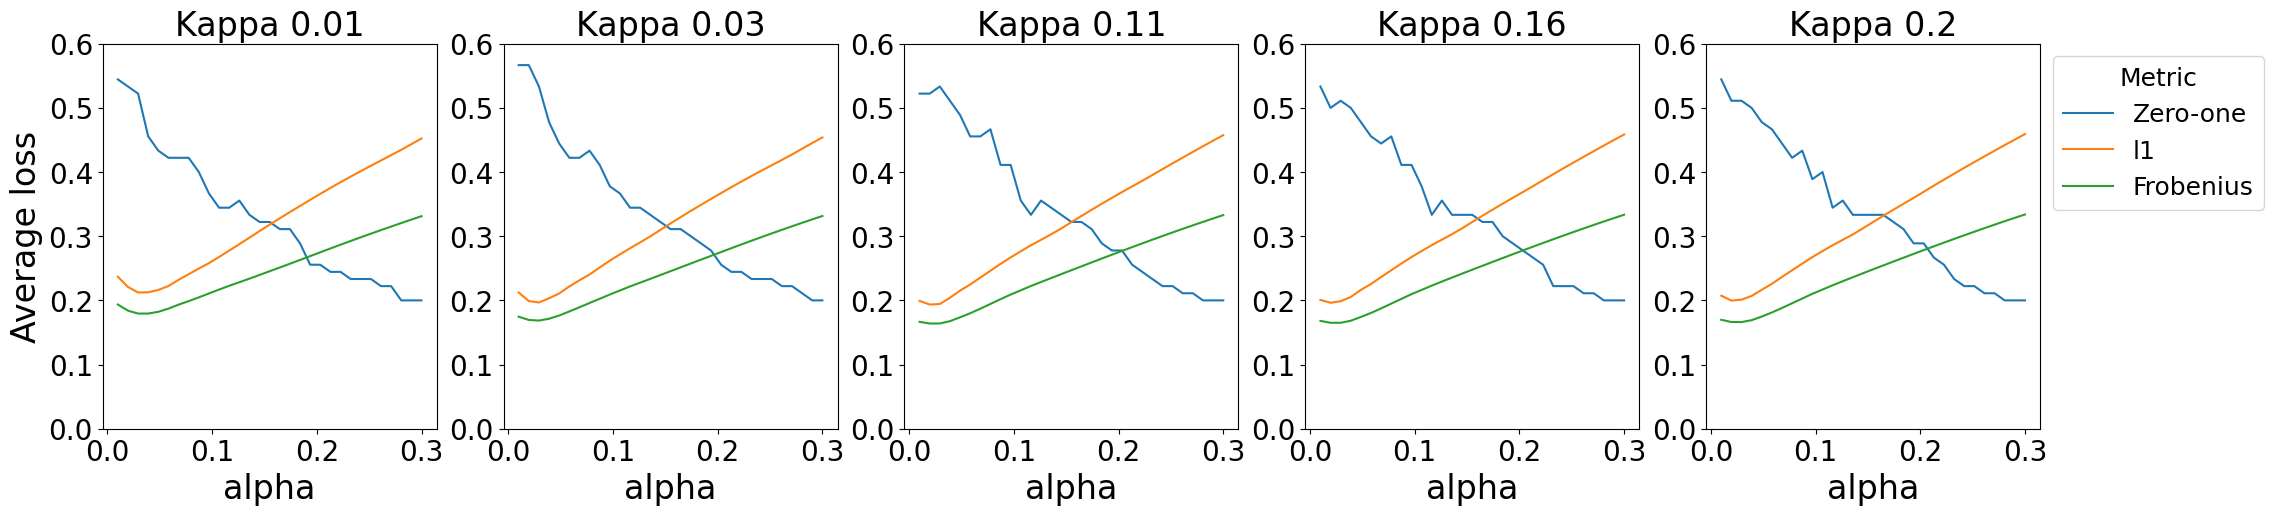

In [6]:
plot_all_metric_per_alpha(change_point_dict, [0,2,10,15, 20], ylim=[0,0.6])

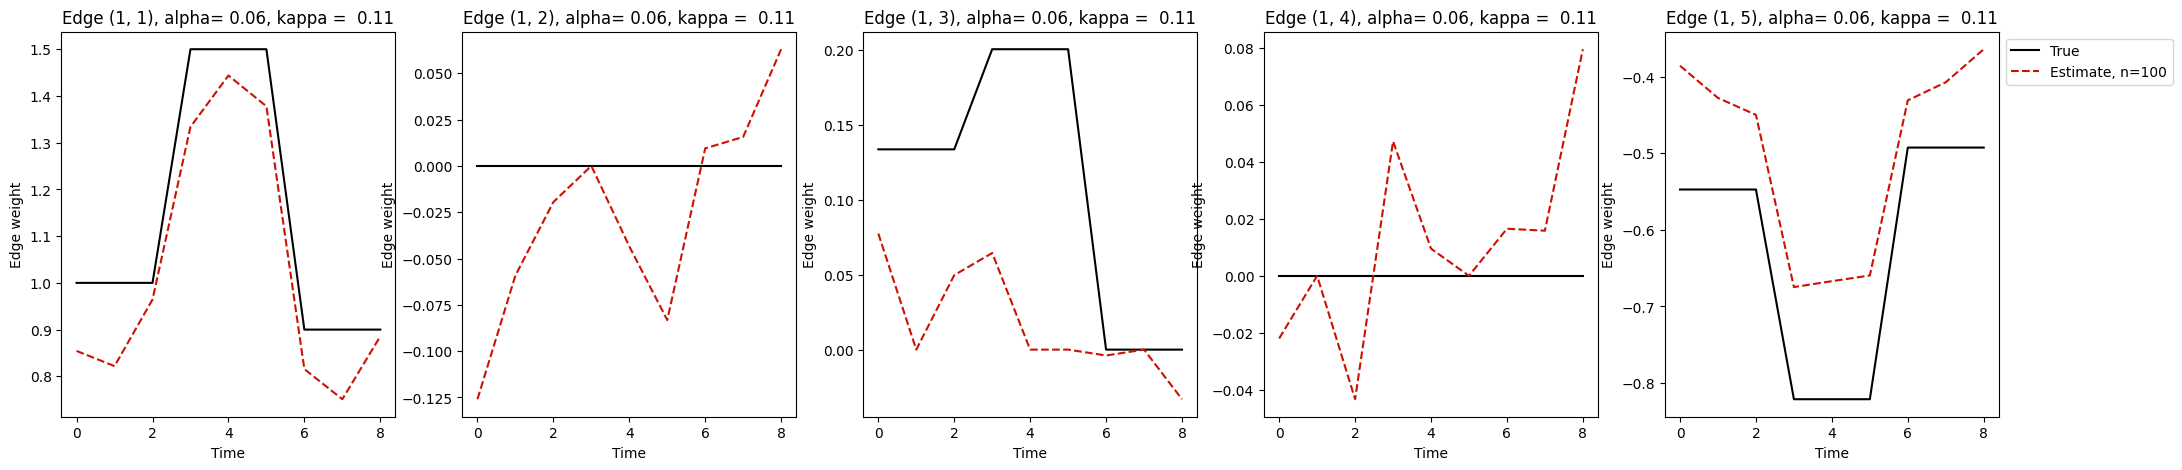

In [97]:
for i in range(1):
    plot_edges([change_point_dict], [(i,0), (i,1), (i,2), (i,3), (i,4)], 5, 10)


# Test

In [115]:
rnd_state = np.random.RandomState(42)
rnd_state2 = np.random.RandomState(1)

alpha = 0.1
kappa = 1
temporal_penalty = 'global-reconstruction'
tol = 1e-10

nr_obs_per_graph = 1000
n = 9*nr_obs_per_graph
d = prec_0.shape[0]
# Simulate 
Xs = np.zeros((n,d))
prec_list = [prec_0]
is_psd = False
cnt = 0
while cnt*nr_obs_per_graph <n:
    if cnt > 0:
        prec_tmp = prec_list[cnt-1].copy()
        
        if cnt == 3:

            prec_tmp = prec_tmp*1.5
        
        if cnt == 6:
            prec_tmp = prec_tmp*0.6
            prec_tmp[0,2] = 0.0
            prec_tmp[2,0] = 0.0
            prec_tmp[4,1] = 0.0
            prec_tmp[1,4] = 0.0
        
        u,v = np.linalg.eigh(prec_tmp)
        if np.any(u<0.0):
            continue
        prec_list.append(prec_tmp)

    Xs[cnt*nr_obs_per_graph:(cnt+1)*nr_obs_per_graph ] = rnd_state2.multivariate_normal(mean = np.zeros(d), cov = np.linalg.inv(prec_list[cnt]),size=(nr_obs_per_graph) )

    cnt +=1


dg_opt1 = dg.dygl_parallel(obs_per_graph = nr_obs_per_graph, max_iter = 2000, lamda = nr_obs_per_graph*alpha, kappa = nr_obs_per_graph*kappa, tol = tol)
dg_opt1.fit(Xs, nr_workers=3, temporal_penalty=temporal_penalty, lik_type="gaussian", verbose=False)

C:\Users/User/Code/DyGraph\DyGraph\dygl_parallel.py:405: UserWarning: Max iterations reached.
  warnings.warn("Max iterations reached.")


In [116]:
calc_one_zero_error(prec_list[0], dg_opt1.theta[0])

0.3

In [117]:
np.round(prec_list[0],2)

array([[ 1.  ,  0.  ,  0.13,  0.  , -0.55],
       [ 0.  ,  1.  ,  0.  ,  0.09, -0.31],
       [ 0.13,  0.  ,  1.  ,  0.  , -0.5 ],
       [ 0.  ,  0.09,  0.  ,  1.  ,  0.  ],
       [-0.55, -0.31, -0.5 ,  0.  ,  1.  ]])

In [118]:
np.round(dg_opt1.theta[0],2)

array([[ 0.96, -0.02,  0.  ,  0.  , -0.43],
       [-0.02,  0.98, -0.01,  0.01, -0.18],
       [ 0.  , -0.01,  0.99,  0.  , -0.39],
       [ 0.  ,  0.01,  0.  ,  1.08,  0.  ],
       [-0.43, -0.18, -0.39,  0.  ,  0.88]])

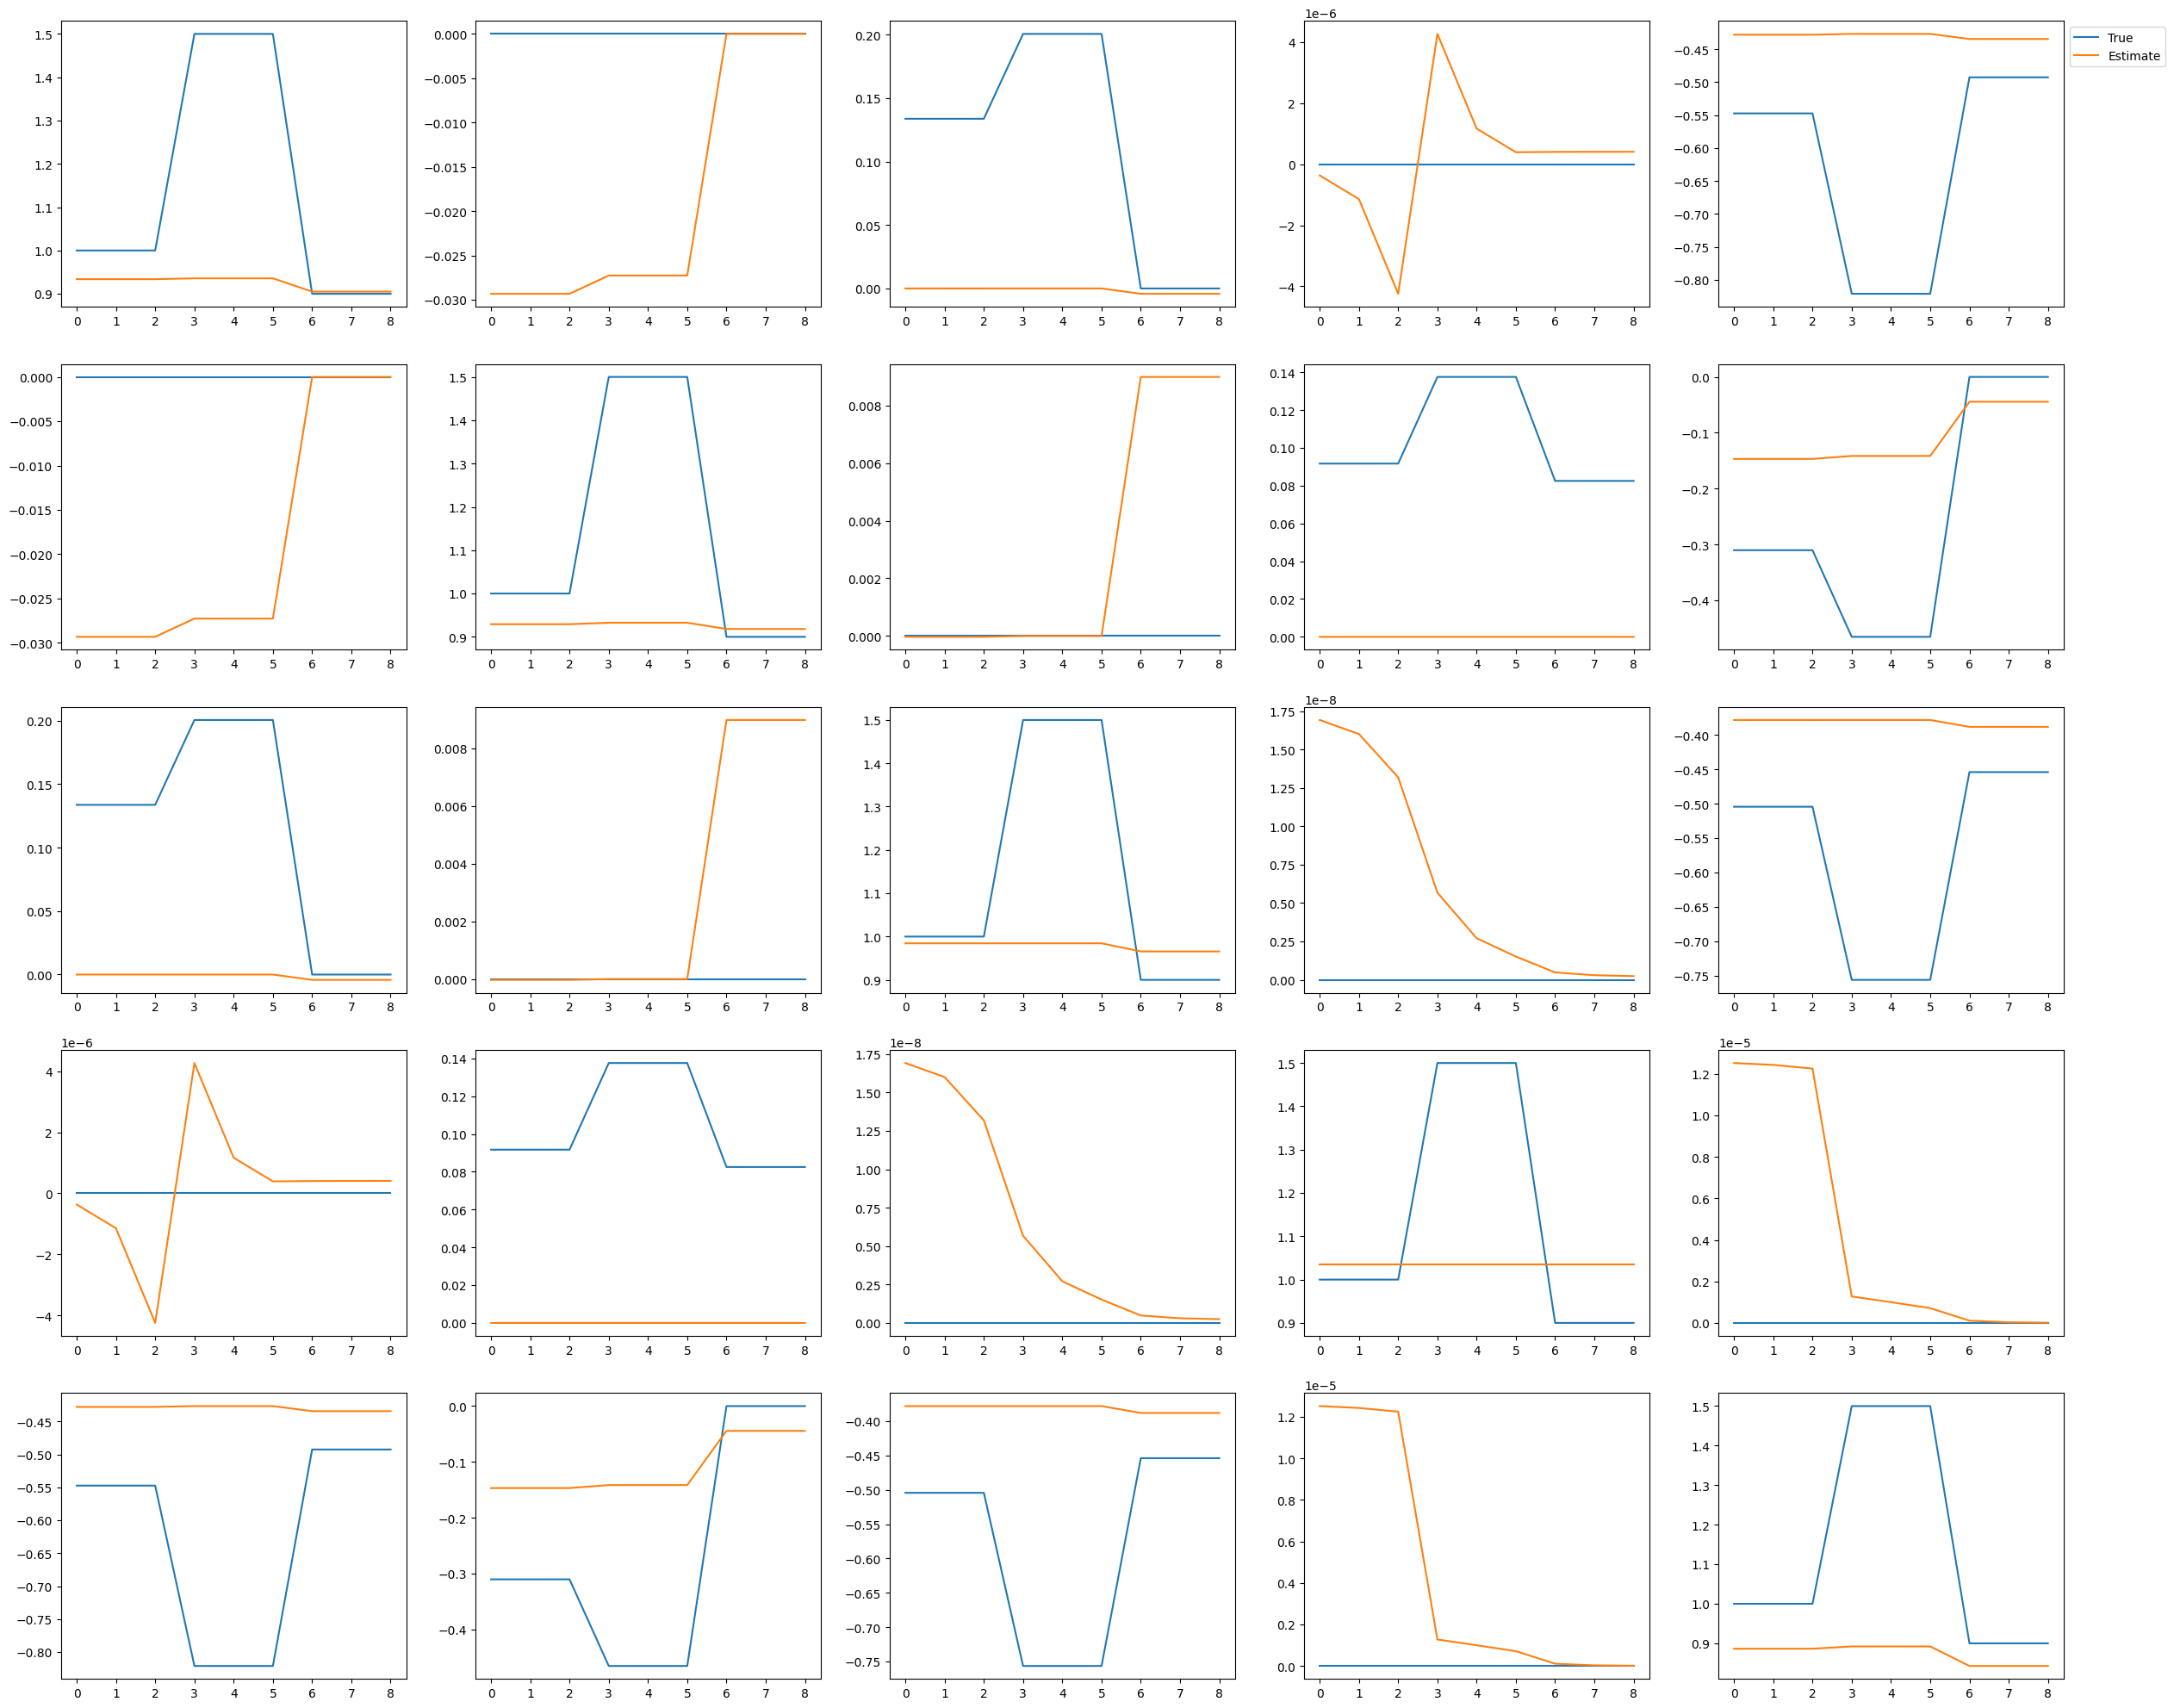

In [111]:
prec_list = np.array(prec_list)
fig, ax = plt.subplots(5,5, figsize = (30,25))

for i in range(d):
    ax[0,i].plot(prec_list[:,0,i], label = "True")
    ax[0,i].plot(dg_opt1.theta[:,0,i], label = "Estimate")
    ax[1,i].plot(prec_list[:,1,i], label = "True")
    ax[1,i].plot(dg_opt1.theta[:,1,i], label = "Estimate")
    ax[2,i].plot(prec_list[:,2,i], label = "True")
    ax[2,i].plot(dg_opt1.theta[:,2,i], label = "Estimate")
    ax[3,i].plot(prec_list[:,3,i], label = "True")
    ax[3,i].plot(dg_opt1.theta[:,3,i], label = "Estimate")
    ax[4,i].plot(prec_list[:,4,i], label = "True")
    ax[4,i].plot(dg_opt1.theta[:,4,i], label = "Estimate")
    if i == d-1:
        ax[0,i].legend(bbox_to_anchor = (1,1))